In [53]:
%load_ext autoreload
%autoreload 2

class StopExecution(Exception):
    def _render_traceback_(self):
        return []



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import sys
sys.path.append("..")
import pickle as pkl
import hist
from analyzer.core import AnalysisResult
from analyzer.datasets import SampleManager
import math
import torch
import gpytorch
from analyzer.plotting.core_plots import *
loadStyles()
import matplotlib
from torch.masked import masked_tensor, as_masked_tensor
matplotlib.rcParams['figure.figsize'] = (3, 3)

In [55]:
res = AnalysisResult.fromFile("../results/newanalyzer.pkl")

In [56]:
sample_manager = SampleManager()
sample_manager.loadSamplesFromDirectory("../datasets")

In [57]:
hists = res.getMergedHistograms(sample_manager)

In [127]:
complete_hist = hists["ratio_m14_vs_m24"]
narrowed = hist
#orig =  m14_vs_m24[...,hist.loc(1100):hist.loc(2500),hist.loc(400):hist.loc(2000)]
#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(1)]
orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(0.4):hist.loc(1)]
orig = orig / orig.values().max()
#orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(400):hist.loc(3000)]#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(3000)]




narrowed = orig
narrowed = orig[...,::hist.rebin(2),::hist.rebin(2)]



qcd_hist = narrowed["Skim_QCDInclusive2018",...]
orig_qcd_hist = orig["Skim_QCDInclusive2018",...]

sig_hist = narrowed["signal_312_1500_900",...]

qcd_hist = narrowed["Skim_QCDInclusive2018",...] + 40 * sig_hist


In [128]:
def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

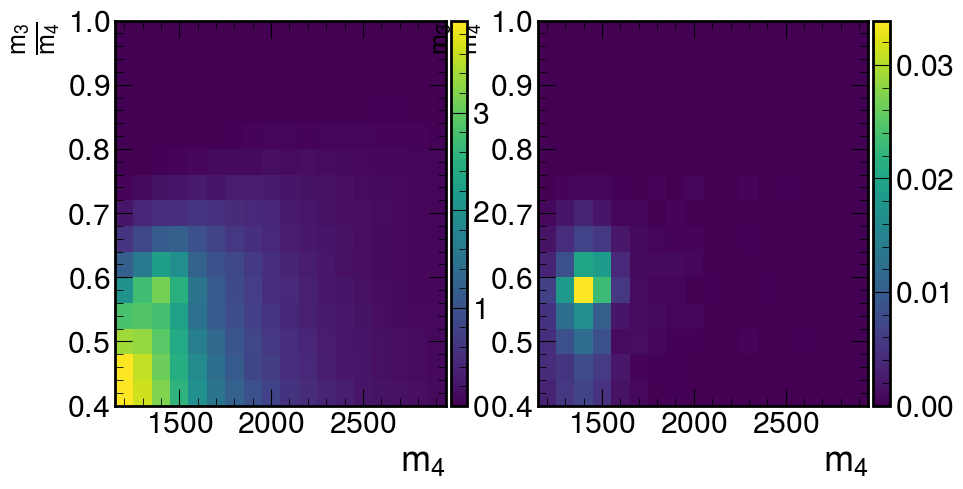

In [129]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
_ = drawAs2DHist(ax[0], PlotObject(qcd_hist))
_ = drawAs2DHist(ax[1], PlotObject(sig_hist))

In [130]:
sig_values = torch.from_numpy(sig_hist.values()).T


def make_mask(x1,x2):
    a = (x1 > 1500 ) | (x1 < 1300) 
    b = (x2 > 0.6 ) | ( x2 < 0.5)
    return a,b

edges_x1 = torch.from_numpy(qcd_hist.axes[0].edges)
edges_x2 = torch.from_numpy(qcd_hist.axes[1].edges)
centers_x1 = torch.diff(edges_x1) /2  + edges_x1[:-1] 
centers_x2 = torch.diff(edges_x2) /2  + edges_x2[:-1] 

bin_values = torch.from_numpy(qcd_hist.values()).T
bin_vars = torch.from_numpy(qcd_hist.variances()).T

emask_x1,emask_x2 = make_mask(edges_x1, edges_x2)
centers_grid_x1,centers_grid_x2 = torch.meshgrid(centers_x1,centers_x2,indexing='xy')

cmask_x1,cmask_x2 = make_mask(centers_x1, centers_x2)


centers_grid = torch.stack((centers_grid_x1,centers_grid_x2), axis=2)
m1,m2 = make_mask(centers_grid[:,:,0] , centers_grid[:,:,1])
centers_mask = m1 | m2
flat_centers = torch.flatten(centers_grid, end_dim=1)
flat_bin_values = torch.flatten(bin_values)
flat_bin_vars = torch.flatten(bin_vars)
ma = torch.max(flat_centers.T,axis=1).values
mi = torch.min(flat_centers.T,axis=1).values
transformed_centers = (flat_centers - mi) / (ma-mi)

ma = torch.max(flat_bin_values)
mi = torch.min(flat_bin_values)
transformed_values = (flat_bin_values - mi)
transformed_vars = (flat_bin_vars) 


flat_centers_masked = transformed_centers[torch.flatten(centers_mask)]
flat_bin_values_masked = transformed_values[torch.flatten(centers_mask)]
flat_bin_vars_masked = transformed_vars[torch.flatten(centers_mask)]

train_x = flat_centers_masked
train_y = flat_bin_values_masked
train_vars = flat_bin_vars_masked
test_x = transformed_centers
test_y = transformed_values
test_vars = transformed_vars

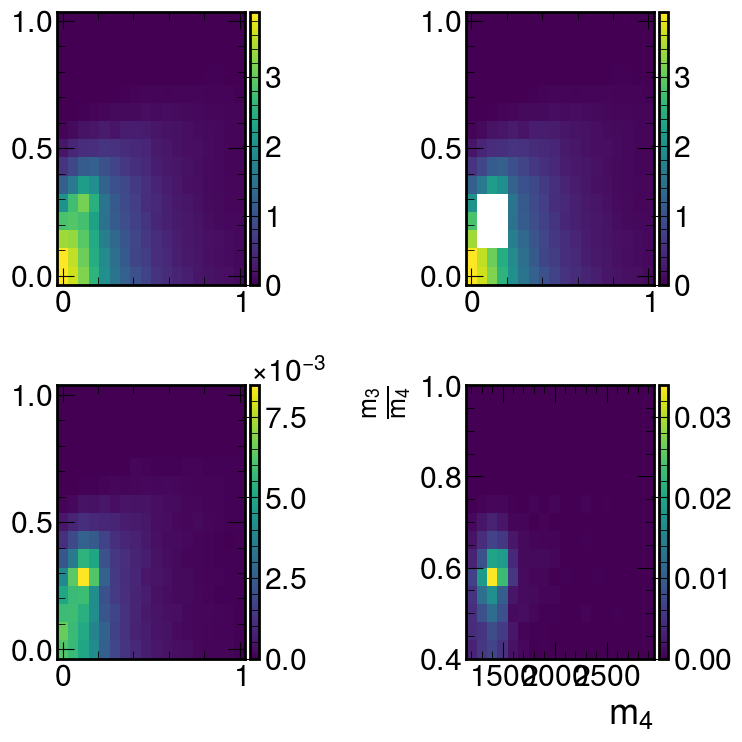

In [131]:
fig,ax = plt.subplots(2,2, figsize=(8,8))
def simpleGrid(ax, inx,iny):
    x=np.unique(inx[:,0])
    y=np.unique(inx[:,1])
    X,Y = np.meshgrid(x,y)
    z=iny
    Z=z.reshape(len(y),len(x))
    f = ax.pcolormesh(X,Y,Z)
    addColorbar(ax,f)
    return f
    
simpleGrid(ax[0,0],test_x,test_y)
simpleGrid(ax[1,0],test_x,test_vars)

simpleGrid(ax[0,1],test_x, np.ma.masked_where(~torch.flatten(centers_mask), test_y))
drawAs2DHist(ax[1,1], PlotObject(sig_hist))
fig.tight_layout()

In [132]:
# We will use the simplest form of GP model, exact inference

class GaussianMean(gpytorch.means.Mean):
    def __init__(self, prior=None, init_mean=0.0, init_sigma=1.0, init_scale=1.0):
        super().__init__()
        self.register_parameter(name="mean", parameter=torch.nn.Parameter(torch.tensor(init_mean,dtype=torch.float64)))   
        self.register_parameter(name="sigma", parameter=torch.nn.Parameter(torch.tensor(init_sigma,dtype=torch.float64)))  
        self.register_parameter(name="scale", parameter=torch.nn.Parameter(torch.tensor(init_scale,dtype=torch.float64)))   
        if prior is not None:
            self.register_prior("contant_prior", prior, "mean")
            self.register_prior("constant_prior", prior, "sigma")
            self.register_prior("constant_prior", prior, "scale")

    def forward(self, input):
        inner = (input-self.mean)**2 @ (1 / self.sigma**2)
        e =  torch.exp(-inner)
        ret = self.scale * e
        return ret

class ExactProjGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean or gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
        #self.proj_mat = torch.nn.Parameter(torch.tensor([[1,1],[1,0]], dtype=torch.float64)) 
        self.rot = torch.nn.Parameter(torch.tensor(0.78,dtype=torch.float64))
    def forward(self, x):
        rot_mat = torch.tensor([
            [torch.cos(self.rot), -torch.sin(self.rot)],
            [torch.sin(self.rot), torch.cos(self.rot)]
        ])
        x = x @ rot_mat   # n x d * d x k --> n x k
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean=None):
        super().__init__(train_x, train_y, likelihood)
        #self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = mean or gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
    
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class ExactPeakedGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
        
        self.covar_peak_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )
        self.peak = torch.nn.Parameter(torch.tensor([0.8,0.2], dtype=torch.float64)) 
        
    def forward(self, x):
        subbed = x-self.peak
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) * self.covar_peak_module(subbed)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class _ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [133]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_vars, learn_additional_noise=False)
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, mean=GaussianMean(None, [0.3,0.3],[0.05,0.05],1.0))
#model = ExactProjGPModel(train_x, train_y, likelihood)
#model = ExactPeakedGPModel(train_x, train_y, likelihood)
# model.covar_module.base_kernel.lengthscale = torch.tensor([200,200])
# model.covar_module.base_kernel.raw_outputscale = 1e7
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')


model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# optimizer = torch.optim.Adam([
#         {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': 20},
#         {'params': model.covar_module.raw_outputscale, 'lr': 5e6},
#         #{'params': model.proj_mat, 'lr': 0.25},   
#         {'params': model.mean_module.parameters(), 'lr': 1e4},
#        # {"params" : model.likelihood.parameters(), 'lr' : 1e2}
# ])


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
print(mll)
iterations = 100
for i in range(iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if not (i+1)% (iterations / 10 ) or i == 0:
        print('Iter {:d} - Loss: {:0.3f}   lengthscale: {:0.4f},{:0.4f}  scale: {:0.3f}  mean:{:0.3f} noise:{:0.3f} '.format(
        i + 1,  loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.covar_module.outputscale.item(),
        model.mean_module.scale.item(), 
        likelihood.noise.mean()
    )
         )
        #print(model.proj_mat)
    optimizer.step()

# this is for running the notebook in our testing framework
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')


#model.covar_module.base_kernel.lengthscale = [0.3,0.3]
#model.proj_mat = torch.nn.Parameter(torch.tensor([[-1,1],[1,-1]], dtype=torch.float64)) 

/srv/cmsmlenv/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Parameter name: mean_module.mean                           value = Parameter containing:
tensor([0.3000, 0.3000], dtype=torch.float64, requires_grad=True)
Parameter name: mean_module.sigma                          value = Parameter containing:
tensor([0.0500, 0.0500], dtype=torch.float64, requires_grad=True)
Parameter name: mean_module.scale                          value = Parameter containing:
tensor(1., dtype=torch.float64, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[0., 0.]], requires_grad=True)
ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): ExactGPModel(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): GaussianMean()
    (covar_module): ScaleKer

In [134]:
print(model.mean_module.scale)
print(model.mean_module.sigma)
print(model.mean_module.mean)

Parameter containing:
tensor(1.1273, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0771, 0.1100], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.1360, 0.3170], dtype=torch.float64, requires_grad=True)


In [135]:
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=test_vars, learn_additional_noise=False)

#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=0.1*torch.ones_like(train_y), learn_additional_noise=False)
#model = ExactGPModel(train_x, train_y, likelihood)



# this is for running the notebook in our testing framework
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')
model.eval()
likelihood.eval()

Parameter name: mean_module.mean                           value = Parameter containing:
tensor([0.1360, 0.3170], dtype=torch.float64, requires_grad=True)
Parameter name: mean_module.sigma                          value = Parameter containing:
tensor([0.0771, 0.1100], dtype=torch.float64, requires_grad=True)
Parameter name: mean_module.scale                          value = Parameter containing:
tensor(1.1273, dtype=torch.float64, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(0.9054, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[-0.8230, -1.5421]], requires_grad=True)


FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

In [136]:
#model.covar_module.base_kernel.lengthscale = [0.01,0.01]

with torch.no_grad(), gpytorch.settings.fast_computations():
    #test_x = train_x.flatten()
    observed_pred = likelihood(model(test_x),noise=test_vars)
    trained_pred_dist = likelihood(model(test_x), noise=test_vars)
    #observed_pred = model(test_x)

tensor(inf, dtype=torch.float64)
PlotObject(hist=NumPyPlottableHistogram(array([ 1,  0,  1,  0,  2,  8,  6, 48, 51, 55, 22,  8,  2,  1,  0,  0,  0,
        0,  0,  1]), <NumPyPlottableAxis(array([[-6.94289941, -6.16881222],
       [-6.16881222, -5.39472503],
       [-5.39472503, -4.62063784],
       [-4.62063784, -3.84655065],
       [-3.84655065, -3.07246346],
       [-3.07246346, -2.29837627],
       [-2.29837627, -1.52428908],
       [-1.52428908, -0.75020189],
       [-0.75020189,  0.0238853 ],
       [ 0.0238853 ,  0.79797249],
       [ 0.79797249,  1.57205968],
       [ 1.57205968,  2.34614687],
       [ 2.34614687,  3.12023405],
       [ 3.12023405,  3.89432124],
       [ 3.89432124,  4.66840843],
       [ 4.66840843,  5.44249562],
       [ 5.44249562,  6.21658281],
       [ 6.21658281,  6.99067   ],
       [ 6.99067   ,  7.76475719],
       [ 7.76475719,  8.53884438]]))>), title=None, style=None)


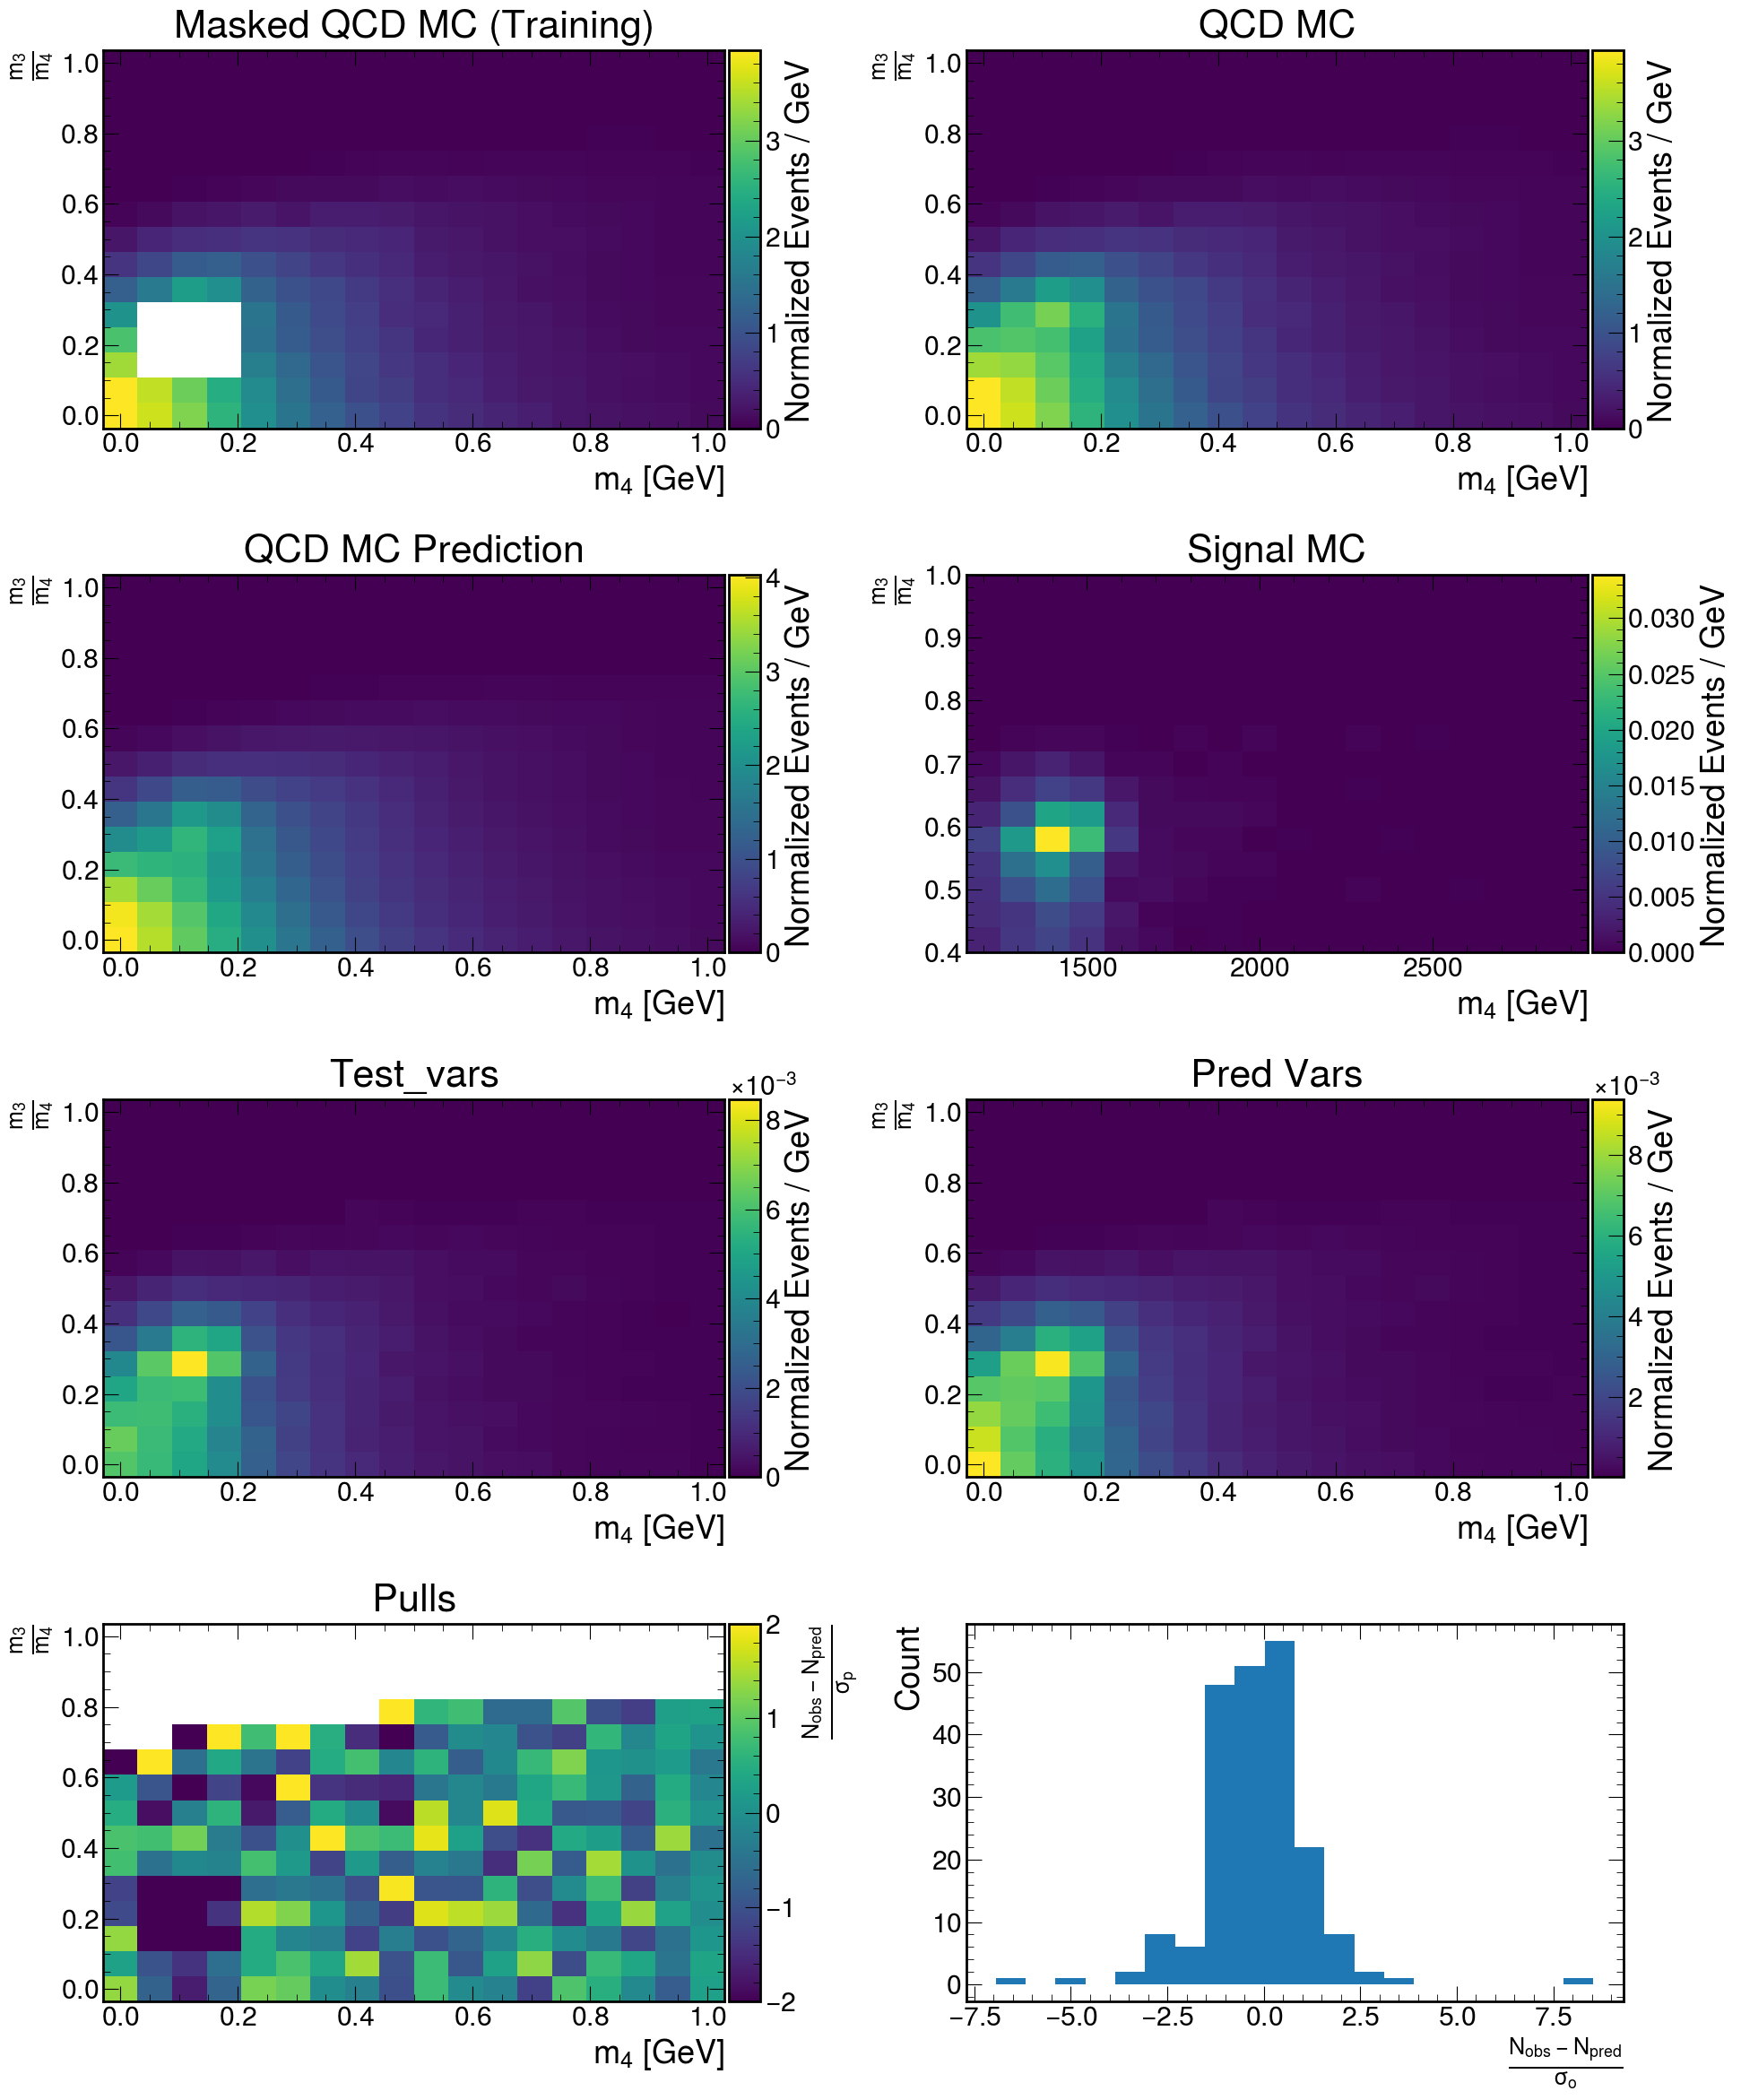

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it


pred_mean = observed_pred.mean
pred_var = observed_pred.variance


all_pulls = (pred_mean - test_y)/ torch.sqrt(test_vars)
all_x2 = (pred_mean - test_y)**2 / test_vars
x2 = torch.sum(all_x2)
print(x2)

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax


fig, ax=plt.subplots(4,2, figsize=(20,24), layout="tight")

f = simpleGrid(ax[0,0], test_x, np.ma.masked_where(~centers_mask,torch.reshape(test_y, centers_mask.shape)))
#ax[0,0].pcolormesh(*torch.unbind(centers_grid,axis=2), np.ma.masked_where(~centers_mask,bin_values))
ax[0,0].set_title("Masked QCD MC (Training)")

f = simpleGrid(ax[1,0], test_x, pred_mean)
#f = ax[1,0].pcolormesh(*torch.unbind(centers_grid,axis=2), r)
ax[1,0].set_title("QCD MC Prediction")



f = simpleGrid(ax[0,1], test_x, test_y)
#f=ax[0,1].pcolormesh(*torch.unbind(centers_grid,axis=2), bin_values)
ax[0,1].set_title("QCD MC")


drawAs2DHist(ax[1,1], PlotObject(sig_hist))
addTitles2D(ax[1,1], sig_hist)
ax[1,1].set_title("Signal MC")


f = simpleGrid(ax[2,0], test_x, test_vars)
ax[2,0].set_title("Test_vars")


f = simpleGrid(ax[2,1], test_x, pred_var)
ax[2,1].set_title("Pred Vars")


f = simpleGrid(ax[3,0], test_x, (pred_mean - test_y)/ torch.sqrt(test_vars))
f.set_clim(-2,2)
ax[3,0].set_title("Pulls")


for  x in it.chain(*ax):
    addTitles2D(x, sig_hist)

ax[3,0].cax.set_ylabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{p}}$")

import uhi

p = PlotObject(uhi.numpy_plottable.ensure_plottable_histogram(np.histogram(all_pulls[torch.abs(all_pulls) < 20], bins=20)))
print(p)
drawAs1DHist(ax[3,1], p, yerr=False)
ax[3,1].set_xlabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{o}}$")
ax[3,1].set_ylabel("Count")


fig.savefig("../figures/current_gp_work.pdf")




In [138]:
from analyzer.plotting.core_plots import PlotObject
from analyzer.plotting.core_plots import *
print(analyzer.__file__)


/srv/notebooks/../analyzer/__init__.py


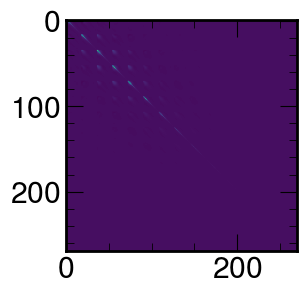

In [139]:
im = observed_pred.covariance_matrix
fig,ax = plt.subplots()
ax.imshow(im)